In [248]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np

from config import Config

In [249]:
class Config:
    # default
    base_path = '../LJSpeech-1.1'
    preprocess_base_path = base_path + '/preprocessed'

    # preprocess
    wav_paths = preprocess_base_path + '/paths'
    mel_paths = preprocess_base_path + '/mels'
    spec_paths = preprocess_base_path + '/specs'
    transcript_paths = preprocess_base_path + '/transcripts'
    phoneme_paths = preprocess_base_path + '/phonemes'

    # metadata
    data_path = base_path + '/wavs'
    metadata_path = base_path + '/metadata.csv'

    # train
    batch_size = 16
    

    # model
    num_phonemes = 70
    num_mels = 80
    embedding_dim = 512
    d_model = 512
    num_heads = 8
    num_encoder_layers = 6
    num_decoder_layers = 6

In [250]:
import librosa
import matplotlib.pyplot as plt

def visualize_specs(S, mel_S, sr):
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')

    plt.subplot(2, 1, 2)
    librosa.display.specshow(mel_S, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.tight_layout()
    plt.show()

In [251]:
class TransformerTTSDataset(Dataset):
    def __init__(self):
        self.phoneme_to_index = {}
        with open(Config.metadata_path, 'r') as f:
            lines = f.readlines()
            self.wav_names = [line.split('|')[0] for line in lines]

    def __len__(self):
        return len(self.wav_names)

    def __getitem__(self, idx):
        wav_name = self.wav_names[idx]

        phoneme = np.load(f'{Config.phoneme_paths}/{wav_name}.npy')
        spectrogram = np.load(f'{Config.spec_paths}/{wav_name}.npy')
        melspectrogram = np.load(f'{Config.mel_paths}/{wav_name}.npy')

        # phoneme to index
        for ph in phoneme:
            if ph not in self.phoneme_to_index:
                self.phoneme_to_index[ph] = len(self.phoneme_to_index) + 1

        phoneme_seq = [self.phoneme_to_index[ph] for ph in phoneme]

        phoneme_seq = torch.LongTensor(phoneme_seq)
        spectrogram = torch.FloatTensor(spectrogram)
        melspectrogram = torch.FloatTensor(melspectrogram)
        
        return (
            phoneme_seq,
            spectrogram,
            melspectrogram
        )

In [252]:
def pad_sequence1D(seq):
    return nn.utils.rnn.pad_sequence(sequences=seq, batch_first=True, padding_value=0)


def pad_sequence2D(seqs):
    B                   = len(seqs)
    T                   = len(seqs[0])
    max_len             = max([len(seq[0]) for seq in seqs])
    padded_mel          = torch.zeros(B, T, max_len, ) # 멜 스펙트로그램 차원 맞춰주기
    for i, seq in enumerate(seqs):
        padded_mel[i, :, :] = -80.0
        padded_mel[i, :seq.size(0), :seq.size(1)] = seq
    return padded_mel


def pad_sequence1D_stops(seqs):
    for seq in seqs:
        seq[-1] = 1
    return nn.utils.rnn.pad_sequence(sequences=seqs, batch_first=True, padding_value=1)

def collate_fn(batch):
    seqs = [item[0] for item in batch]
    spectrograms = [item[1] for item in batch]
    melspectrograms = [item[2] for item in batch]
    stops = [torch.zeros_like(mel[0]) for mel in melspectrograms]

    seq_lens = torch.LongTensor([len(mel[0]) for mel in melspectrograms])
    padded_seqs = pad_sequence1D(seqs)
    padded_spectrograms = pad_sequence2D(spectrograms)
    padded_melspectrograms = pad_sequence2D(melspectrograms)
    padded_stop_seqs = pad_sequence1D_stops(stops)

    return padded_seqs, padded_spectrograms, padded_melspectrograms, padded_stop_seqs, seq_lens

In [253]:
class Prenet(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(Prenet, self).__init__()
        self.in_dim = in_dim
        self.layers = nn.Sequential(
            nn.Conv1d(in_dim, hidden_dim, kernel_size=5, padding=5//2),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv1d(hidden_dim, out_dim, kernel_size=5, padding=5//2),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv1d(hidden_dim, out_dim, kernel_size=5, padding=5//2),
            nn.BatchNorm1d(out_dim),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.linear = nn.Linear(out_dim, out_dim)

    def forward(self, x):

        x = x.transpose(1, 2)
        x = self.layers(x)
        x = x.transpose(1, 2)
        return self.linear(x)

In [254]:
class ScaledPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(ScaledPositionalEncoding, self).__init__()
        self.d_model = d_model
        self.max_len = max_len

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

        self.alpha = nn.Parameter(torch.ones(1))

    def forward(self, x):
        return x + self.alpha * self.pe[:, :x.size(1)]

In [255]:
class PostNet(nn.Module):
    def __init__(self):
        super(PostNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv1d(80, 512, kernel_size=5, padding=5//2),
            nn.BatchNorm1d(512),
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.Conv1d(512, 512, kernel_size=5, padding=5//2),
            nn.BatchNorm1d(512),
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.Conv1d(512, 512, kernel_size=5, padding=5//2),
            nn.BatchNorm1d(512),
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.Conv1d(512, 512, kernel_size=5, padding=5//2),
            nn.BatchNorm1d(512),
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.Conv1d(512, 80, kernel_size=5, padding=5//2),
            nn.BatchNorm1d(80),
            nn.Dropout(0.5)
        )
        self.linear = nn.Linear(80, 80)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.layers(x)
        x = x.transpose(1, 2)
        return self.linear(x)

In [256]:
class TransformerTTS(nn.Module):
   
    def __init__(self):
        super(TransformerTTS, self).__init__()
        self.phoneme_embedding = nn.Embedding(num_embeddings=Config.num_phonemes, embedding_dim=Config.embedding_dim)
        self.encoder_prenet = Prenet(Config.embedding_dim, 512, 512)
        self.decoder_prenet = Prenet(Config.num_mels, 512, 512)
        
        self.scaled_positional_encoding = ScaledPositionalEncoding(Config.d_model)
        self.transformer = nn.Transformer(
            d_model=Config.d_model,
            num_encoder_layers=Config.num_encoder_layers,
            num_decoder_layers=Config.num_decoder_layers,
            nhead=Config.num_heads,
            batch_first=True,
        )
        
        self.mel_linear = nn.Linear(Config.d_model, Config.num_mels)
        self.stop_linear = nn.Linear(Config.d_model, 1)
        self.sigmoid = nn.Sigmoid()

        self.postnet = PostNet()


    def forward(self, phoneme_seq, spectrogram, seq_lens):
        phoneme_embedding = self.phoneme_embedding(phoneme_seq)
        print('phoneme을 512차원 embedding vector로 변환', phoneme_embedding.shape)
        encoder_prenet_out = self.encoder_prenet(phoneme_embedding)
        print('encoder_prenet_out', encoder_prenet_out.shape)
        phoneme_pe = self.scaled_positional_encoding(encoder_prenet_out)
        print('positional_encoded', phoneme_pe.shape)

        spectrogram = spectrogram.transpose(1, 2)
        decoder_prenet_out = self.decoder_prenet(spectrogram)
        print('decoder_prenet_out', decoder_prenet_out.shape)
        spectrogram_pe = self.scaled_positional_encoding(decoder_prenet_out)
        print('positional_encoded', spectrogram_pe.shape)
        
        transformer_out = self.transformer(phoneme_pe, spectrogram_pe)
        print('transformer_out', transformer_out.shape)

        mel_linear_out = self.mel_linear(transformer_out)
        print('mel_linear_out', mel_linear_out.shape)

        postnet_out = self.postnet(mel_linear_out)
        print('postnet_out', postnet_out.shape)

        mel_pred = mel_linear_out + postnet_out

        stop_token = self.sigmoid(self.stop_linear(transformer_out))
        print('stop_token', stop_token.shape)
        
        mel_pred = mel_pred.transpose(1, 2)
        stop_token = stop_token.squeeze(-1)

        # mel_pred에서 seq_len을 넘어가는 부분은 모두 -80.0 으로 채워준다.
        for i, seq_len in enumerate(seq_lens):
            mel_pred[i, :, seq_len:] = -80.0
            
        return mel_pred, stop_token

In [257]:
class TransformerTTSLoss():
    def __init__(self):
        self.mel_loss = nn.MSELoss()
        self.stop_loss = nn.BCELoss()
        self.alpha = 5.0

    def __call__(self, mel_pred, mel_target, stop_pred, stop_target):
        mel_loss = self.mel_loss(mel_pred, mel_target)
        stop_loss = self.stop_loss(stop_pred, stop_target)
        return mel_loss + stop_loss * self.alpha

3275
phoneme torch.Size([4, 119]), spec: torch.Size([4, 1025, 390]), mel: torch.Size([4, 80, 390]), stop: torch.Size([4, 390]), seq_len: tensor([349, 218, 297, 390])
tensor([349, 218, 297, 390])
- model information
phoneme을 512차원 embedding vector로 변환 torch.Size([4, 119, 512])
encoder_prenet_out torch.Size([4, 119, 512])
positional_encoded torch.Size([4, 119, 512])
decoder_prenet_out torch.Size([4, 390, 512])
positional_encoded torch.Size([4, 390, 512])
transformer_out torch.Size([4, 390, 512])
mel_linear_out torch.Size([4, 390, 80])
postnet_out torch.Size([4, 390, 80])
stop_token torch.Size([4, 390, 1])
loss: 2347.611572265625


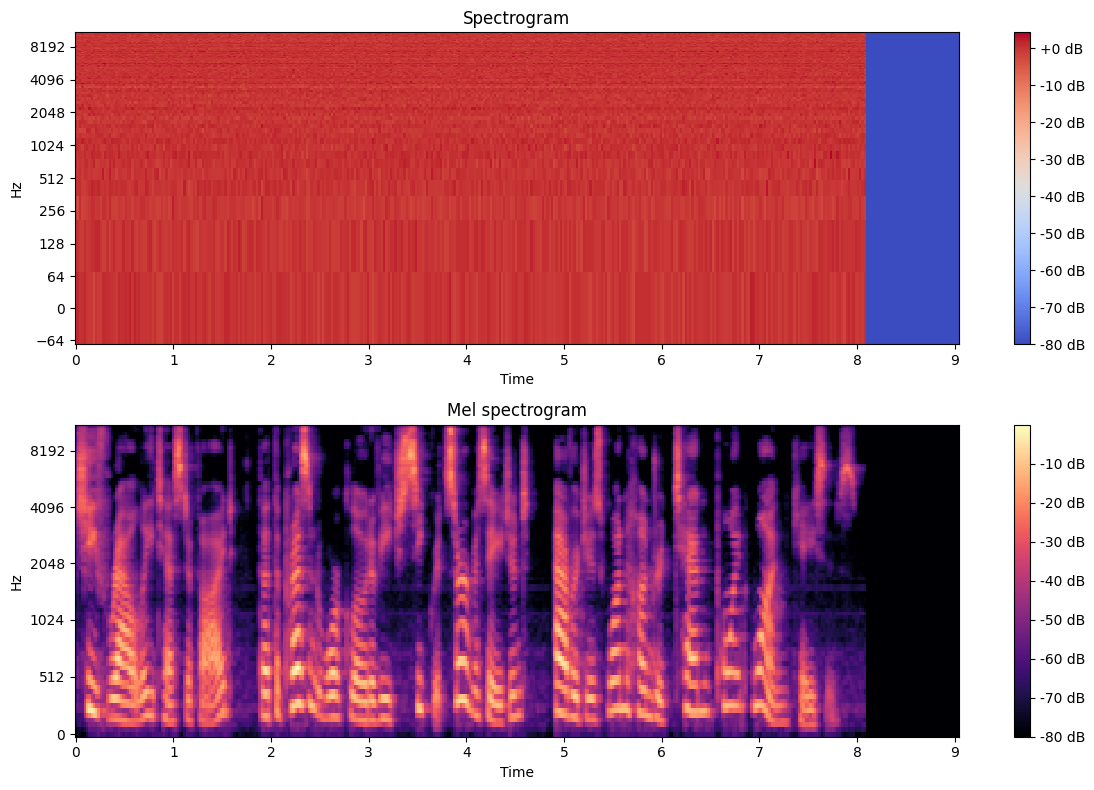

phoneme torch.Size([4, 97]), spec: torch.Size([4, 1025, 291]), mel: torch.Size([4, 80, 291]), stop: torch.Size([4, 291]), seq_len: tensor([ 96, 291, 182, 158])
tensor([ 96, 291, 182, 158])
- model information
phoneme을 512차원 embedding vector로 변환 torch.Size([4, 97, 512])
encoder_prenet_out torch.Size([4, 97, 512])
positional_encoded torch.Size([4, 97, 512])
decoder_prenet_out torch.Size([4, 291, 512])
positional_encoded torch.Size([4, 291, 512])
transformer_out torch.Size([4, 291, 512])
mel_linear_out torch.Size([4, 291, 80])
postnet_out torch.Size([4, 291, 80])
stop_token torch.Size([4, 291, 1])
loss: 1498.8271484375
phoneme torch.Size([4, 126]), spec: torch.Size([4, 1025, 381]), mel: torch.Size([4, 80, 381]), stop: torch.Size([4, 381]), seq_len: tensor([373, 380, 381, 280])
tensor([373, 380, 381, 280])
- model information
phoneme을 512차원 embedding vector로 변환 torch.Size([4, 126, 512])
encoder_prenet_out torch.Size([4, 126, 512])
positional_encoded torch.Size([4, 126, 512])
decoder_prenet

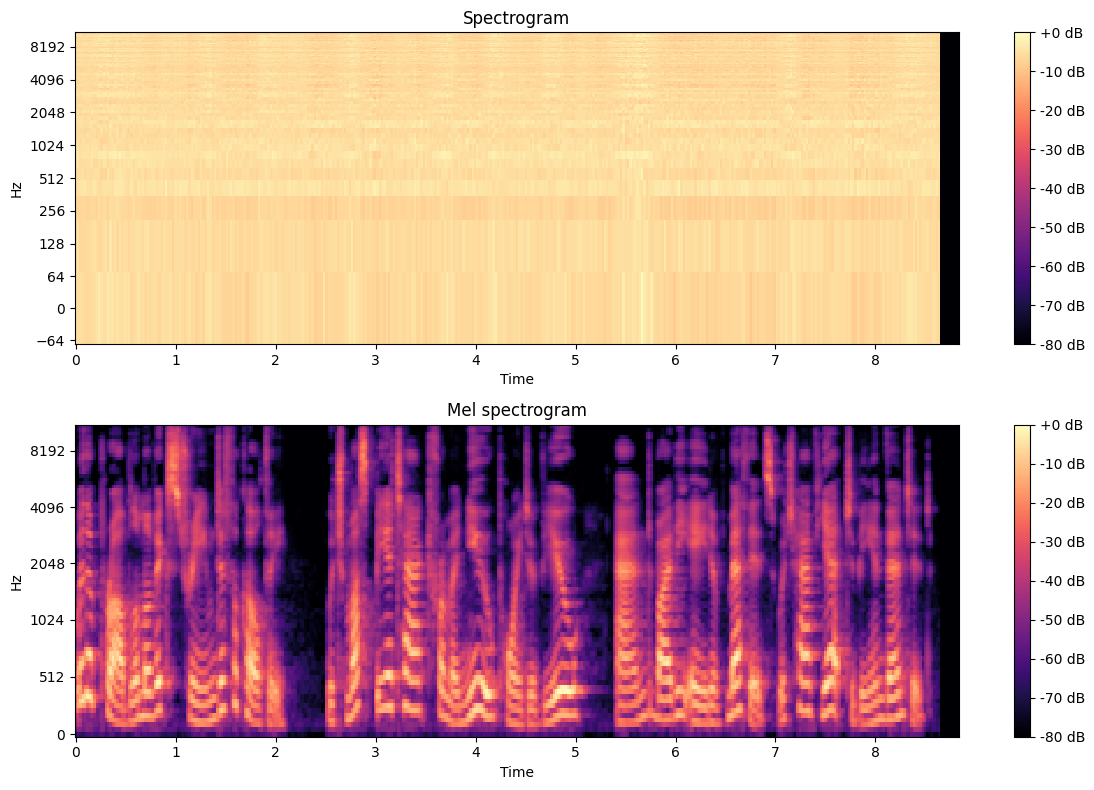

phoneme torch.Size([4, 109]), spec: torch.Size([4, 1025, 404]), mel: torch.Size([4, 80, 404]), stop: torch.Size([4, 404]), seq_len: tensor([340, 301, 335, 404])
tensor([340, 301, 335, 404])
- model information
phoneme을 512차원 embedding vector로 변환 torch.Size([4, 109, 512])
encoder_prenet_out torch.Size([4, 109, 512])
positional_encoded torch.Size([4, 109, 512])
decoder_prenet_out torch.Size([4, 404, 512])
positional_encoded torch.Size([4, 404, 512])
transformer_out torch.Size([4, 404, 512])
mel_linear_out torch.Size([4, 404, 80])
postnet_out torch.Size([4, 404, 80])
stop_token torch.Size([4, 404, 1])
loss: 1720.9139404296875
phoneme torch.Size([4, 114]), spec: torch.Size([4, 1025, 400]), mel: torch.Size([4, 80, 400]), stop: torch.Size([4, 400]), seq_len: tensor([202, 333, 400, 265])
tensor([202, 333, 400, 265])
- model information
phoneme을 512차원 embedding vector로 변환 torch.Size([4, 114, 512])
encoder_prenet_out torch.Size([4, 114, 512])
positional_encoded torch.Size([4, 114, 512])
decoder

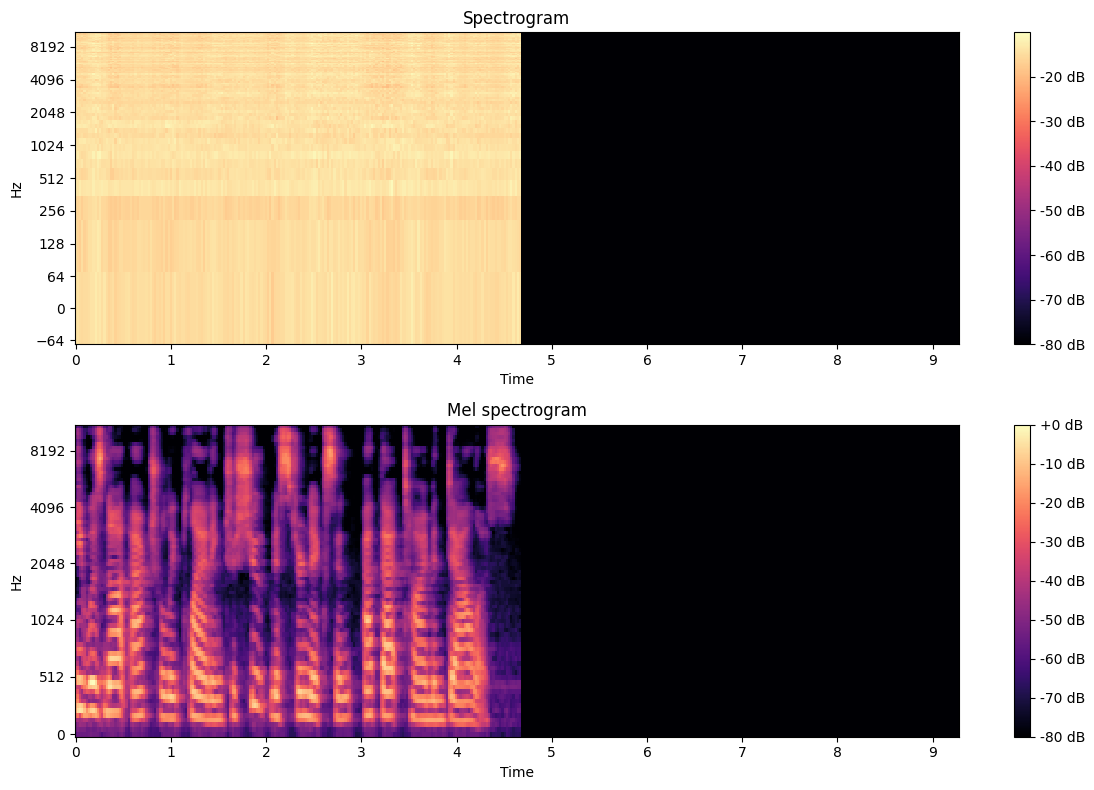

phoneme torch.Size([4, 120]), spec: torch.Size([4, 1025, 390]), mel: torch.Size([4, 80, 390]), stop: torch.Size([4, 390]), seq_len: tensor([232, 336, 390, 142])
tensor([232, 336, 390, 142])
- model information
phoneme을 512차원 embedding vector로 변환 torch.Size([4, 120, 512])
encoder_prenet_out torch.Size([4, 120, 512])
positional_encoded torch.Size([4, 120, 512])
decoder_prenet_out torch.Size([4, 390, 512])
positional_encoded torch.Size([4, 390, 512])
transformer_out torch.Size([4, 390, 512])
mel_linear_out torch.Size([4, 390, 80])
postnet_out torch.Size([4, 390, 80])
stop_token torch.Size([4, 390, 1])
loss: 991.8905029296875
phoneme torch.Size([4, 138]), spec: torch.Size([4, 1025, 407]), mel: torch.Size([4, 80, 407]), stop: torch.Size([4, 407]), seq_len: tensor([361, 407, 175, 102])
tensor([361, 407, 175, 102])
- model information
phoneme을 512차원 embedding vector로 변환 torch.Size([4, 138, 512])
encoder_prenet_out torch.Size([4, 138, 512])
positional_encoded torch.Size([4, 138, 512])
decoder_

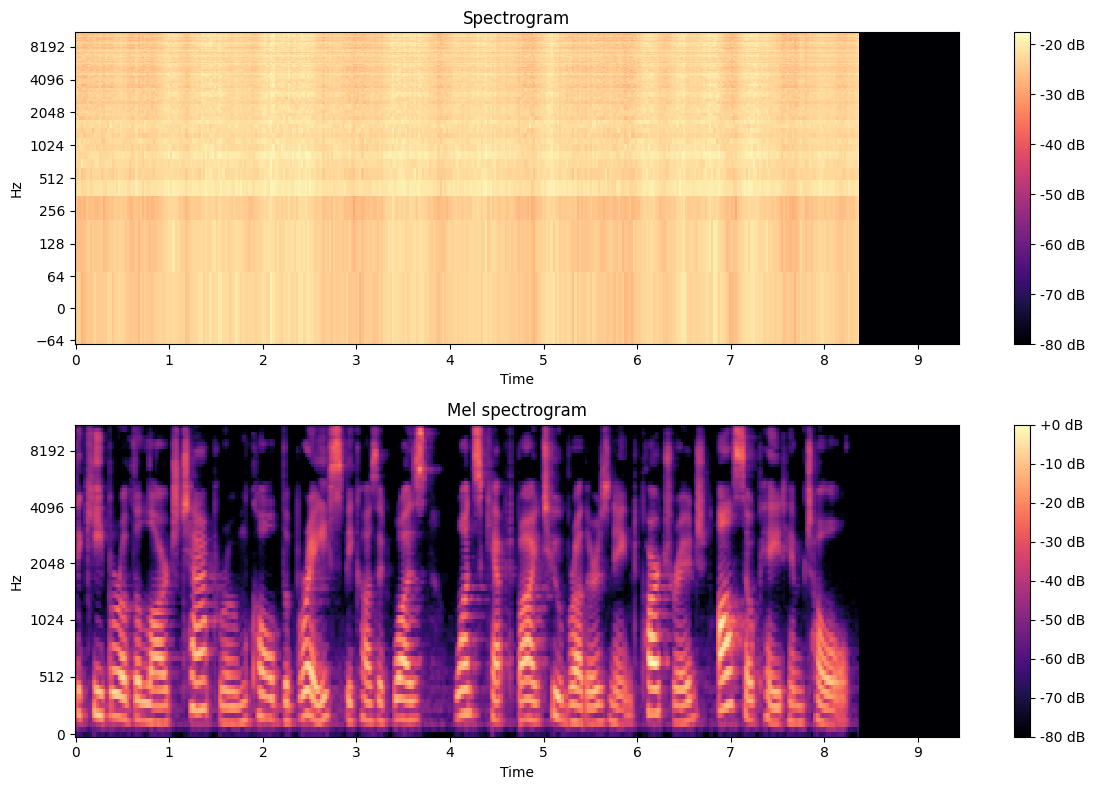

phoneme torch.Size([4, 131]), spec: torch.Size([4, 1025, 415]), mel: torch.Size([4, 80, 415]), stop: torch.Size([4, 415]), seq_len: tensor([119, 221, 346, 415])
tensor([119, 221, 346, 415])
- model information
phoneme을 512차원 embedding vector로 변환 torch.Size([4, 131, 512])
encoder_prenet_out torch.Size([4, 131, 512])
positional_encoded torch.Size([4, 131, 512])
decoder_prenet_out torch.Size([4, 415, 512])
positional_encoded torch.Size([4, 415, 512])
transformer_out torch.Size([4, 415, 512])
mel_linear_out torch.Size([4, 415, 80])
postnet_out torch.Size([4, 415, 80])
stop_token torch.Size([4, 415, 1])
loss: 650.6812133789062
phoneme torch.Size([4, 119]), spec: torch.Size([4, 1025, 379]), mel: torch.Size([4, 80, 379]), stop: torch.Size([4, 379]), seq_len: tensor([183, 160, 271, 379])
tensor([183, 160, 271, 379])
- model information
phoneme을 512차원 embedding vector로 변환 torch.Size([4, 119, 512])
encoder_prenet_out torch.Size([4, 119, 512])
positional_encoded torch.Size([4, 119, 512])
decoder_

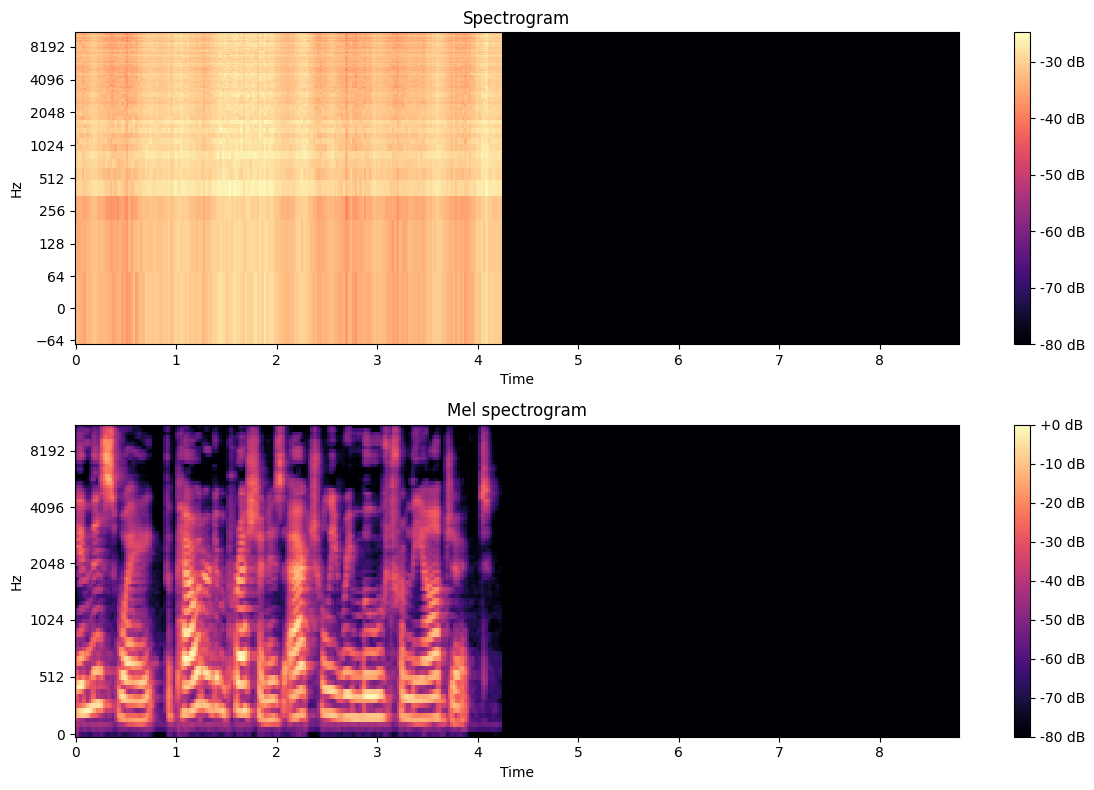

phoneme torch.Size([4, 131]), spec: torch.Size([4, 1025, 424]), mel: torch.Size([4, 80, 424]), stop: torch.Size([4, 424]), seq_len: tensor([125, 260, 424, 398])
tensor([125, 260, 424, 398])
- model information
phoneme을 512차원 embedding vector로 변환 torch.Size([4, 131, 512])
encoder_prenet_out torch.Size([4, 131, 512])
positional_encoded torch.Size([4, 131, 512])
decoder_prenet_out torch.Size([4, 424, 512])
positional_encoded torch.Size([4, 424, 512])
transformer_out torch.Size([4, 424, 512])
mel_linear_out torch.Size([4, 424, 80])
postnet_out torch.Size([4, 424, 80])
stop_token torch.Size([4, 424, 1])
loss: 429.53118896484375
phoneme torch.Size([4, 128]), spec: torch.Size([4, 1025, 374]), mel: torch.Size([4, 80, 374]), stop: torch.Size([4, 374]), seq_len: tensor([291, 374, 367, 336])
tensor([291, 374, 367, 336])
- model information
phoneme을 512차원 embedding vector로 변환 torch.Size([4, 128, 512])
encoder_prenet_out torch.Size([4, 128, 512])
positional_encoded torch.Size([4, 128, 512])
decoder

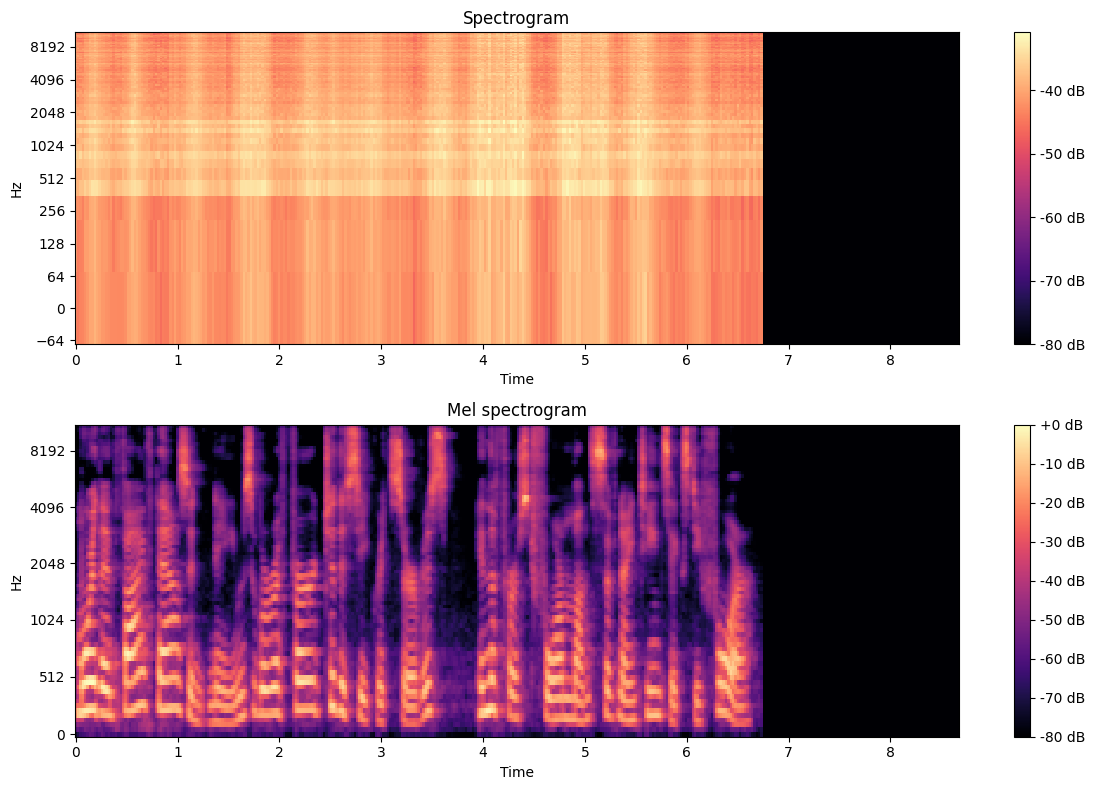

phoneme torch.Size([4, 126]), spec: torch.Size([4, 1025, 385]), mel: torch.Size([4, 80, 385]), stop: torch.Size([4, 385]), seq_len: tensor([377, 324, 385, 318])
tensor([377, 324, 385, 318])
- model information
phoneme을 512차원 embedding vector로 변환 torch.Size([4, 126, 512])
encoder_prenet_out torch.Size([4, 126, 512])
positional_encoded torch.Size([4, 126, 512])
decoder_prenet_out torch.Size([4, 385, 512])
positional_encoded torch.Size([4, 385, 512])
transformer_out torch.Size([4, 385, 512])
mel_linear_out torch.Size([4, 385, 80])
postnet_out torch.Size([4, 385, 80])
stop_token torch.Size([4, 385, 1])
loss: 347.43536376953125
phoneme torch.Size([4, 128]), spec: torch.Size([4, 1025, 330]), mel: torch.Size([4, 80, 330]), stop: torch.Size([4, 330]), seq_len: tensor([330, 321,  75, 230])
tensor([330, 321,  75, 230])
- model information
phoneme을 512차원 embedding vector로 변환 torch.Size([4, 128, 512])
encoder_prenet_out torch.Size([4, 128, 512])
positional_encoded torch.Size([4, 128, 512])
decoder

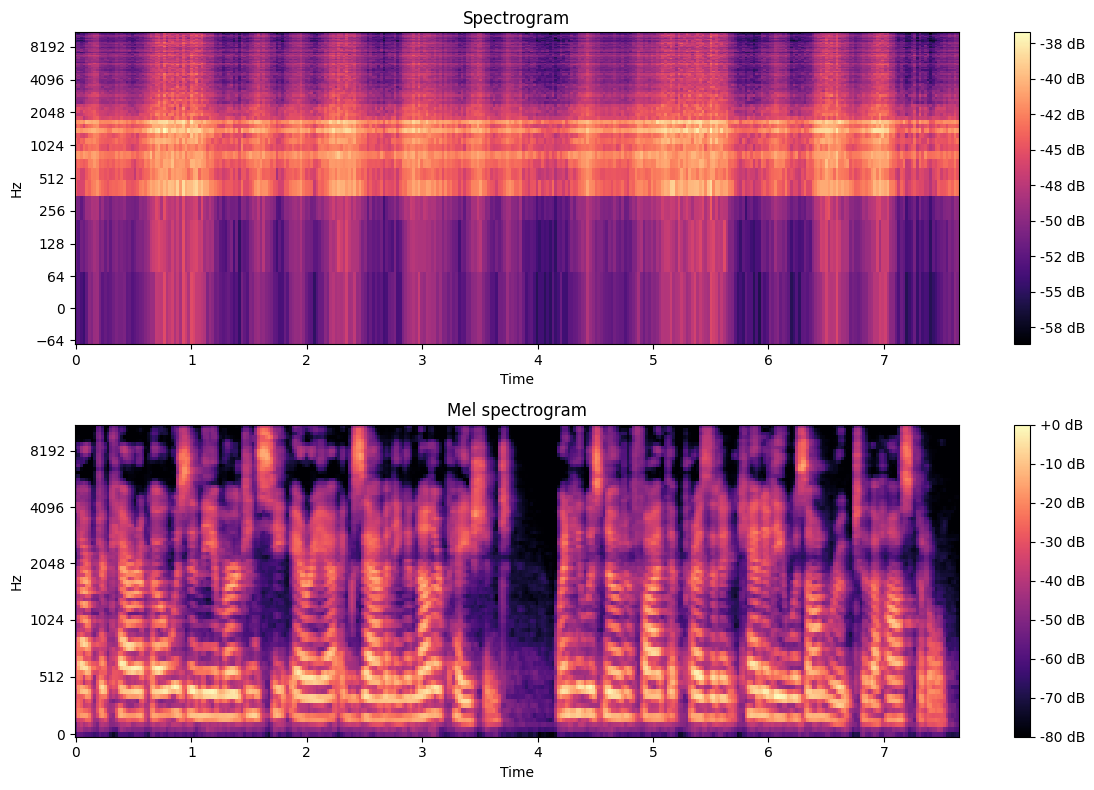

phoneme torch.Size([4, 125]), spec: torch.Size([4, 1025, 419]), mel: torch.Size([4, 80, 419]), stop: torch.Size([4, 419]), seq_len: tensor([386, 159, 419, 157])
tensor([386, 159, 419, 157])
- model information
phoneme을 512차원 embedding vector로 변환 torch.Size([4, 125, 512])
encoder_prenet_out torch.Size([4, 125, 512])
positional_encoded torch.Size([4, 125, 512])
decoder_prenet_out torch.Size([4, 419, 512])
positional_encoded torch.Size([4, 419, 512])
transformer_out torch.Size([4, 419, 512])
mel_linear_out torch.Size([4, 419, 80])
postnet_out torch.Size([4, 419, 80])
stop_token torch.Size([4, 419, 1])
loss: 171.529296875
phoneme torch.Size([4, 143]), spec: torch.Size([4, 1025, 400]), mel: torch.Size([4, 80, 400]), stop: torch.Size([4, 400]), seq_len: tensor([128, 400, 200, 144])
tensor([128, 400, 200, 144])
- model information
phoneme을 512차원 embedding vector로 변환 torch.Size([4, 143, 512])
encoder_prenet_out torch.Size([4, 143, 512])
positional_encoded torch.Size([4, 143, 512])
decoder_pren

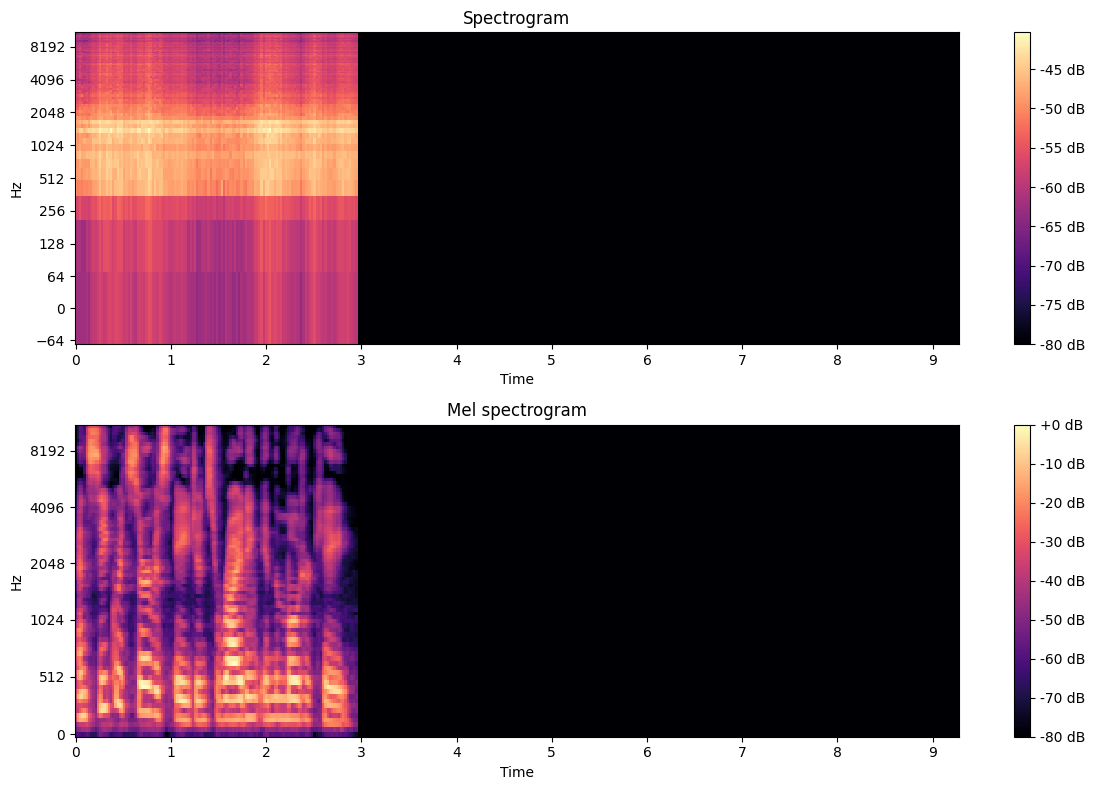

phoneme torch.Size([4, 117]), spec: torch.Size([4, 1025, 371]), mel: torch.Size([4, 80, 371]), stop: torch.Size([4, 371]), seq_len: tensor([194, 371, 277, 313])
tensor([194, 371, 277, 313])
- model information
phoneme을 512차원 embedding vector로 변환 torch.Size([4, 117, 512])
encoder_prenet_out torch.Size([4, 117, 512])
positional_encoded torch.Size([4, 117, 512])
decoder_prenet_out torch.Size([4, 371, 512])
positional_encoded torch.Size([4, 371, 512])
transformer_out torch.Size([4, 371, 512])
mel_linear_out torch.Size([4, 371, 80])
postnet_out torch.Size([4, 371, 80])
stop_token torch.Size([4, 371, 1])
loss: 259.4328308105469
phoneme torch.Size([4, 106]), spec: torch.Size([4, 1025, 396]), mel: torch.Size([4, 80, 396]), stop: torch.Size([4, 396]), seq_len: tensor([185,  73, 271, 396])
tensor([185,  73, 271, 396])
- model information
phoneme을 512차원 embedding vector로 변환 torch.Size([4, 106, 512])
encoder_prenet_out torch.Size([4, 106, 512])
positional_encoded torch.Size([4, 106, 512])
decoder_

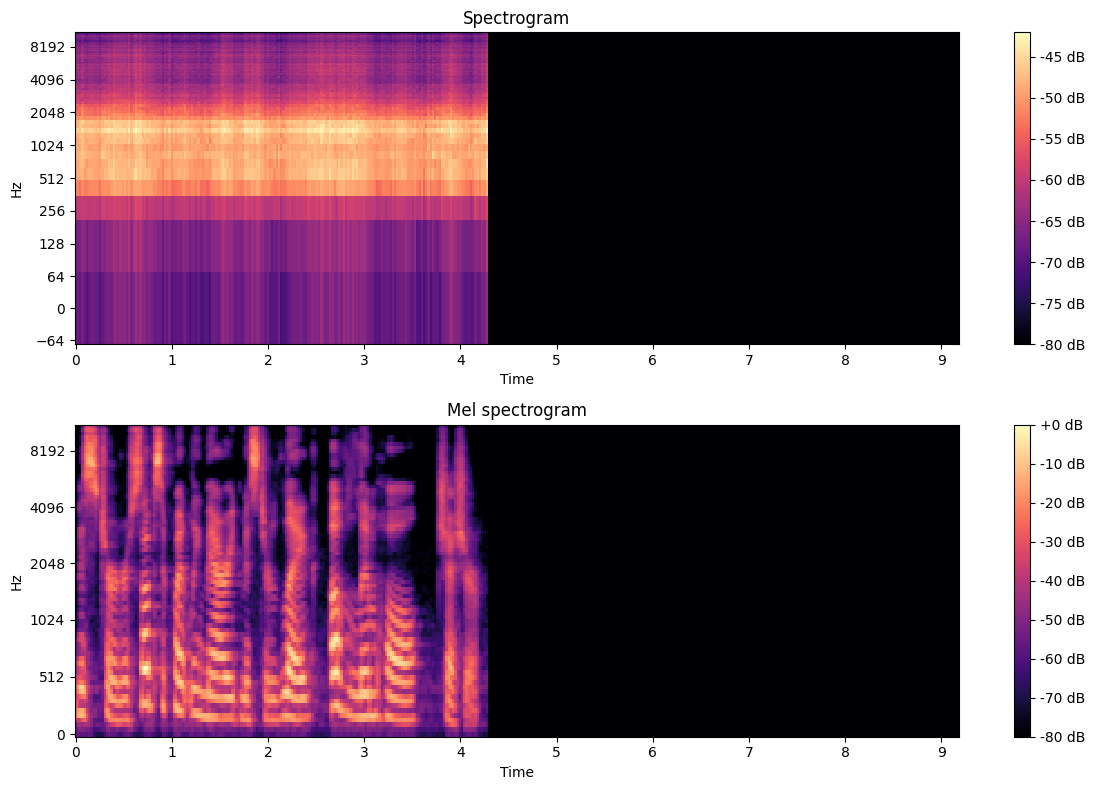

phoneme torch.Size([4, 112]), spec: torch.Size([4, 1025, 339]), mel: torch.Size([4, 80, 339]), stop: torch.Size([4, 339]), seq_len: tensor([302, 129, 339, 149])
tensor([302, 129, 339, 149])
- model information
phoneme을 512차원 embedding vector로 변환 torch.Size([4, 112, 512])
encoder_prenet_out torch.Size([4, 112, 512])
positional_encoded torch.Size([4, 112, 512])
decoder_prenet_out torch.Size([4, 339, 512])
positional_encoded torch.Size([4, 339, 512])
transformer_out torch.Size([4, 339, 512])
mel_linear_out torch.Size([4, 339, 80])
postnet_out torch.Size([4, 339, 80])
stop_token torch.Size([4, 339, 1])
loss: 246.36366271972656
phoneme torch.Size([4, 113]), spec: torch.Size([4, 1025, 359]), mel: torch.Size([4, 80, 359]), stop: torch.Size([4, 359]), seq_len: tensor([350, 347, 160, 359])
tensor([350, 347, 160, 359])
- model information
phoneme을 512차원 embedding vector로 변환 torch.Size([4, 113, 512])
encoder_prenet_out torch.Size([4, 113, 512])
positional_encoded torch.Size([4, 113, 512])
decoder

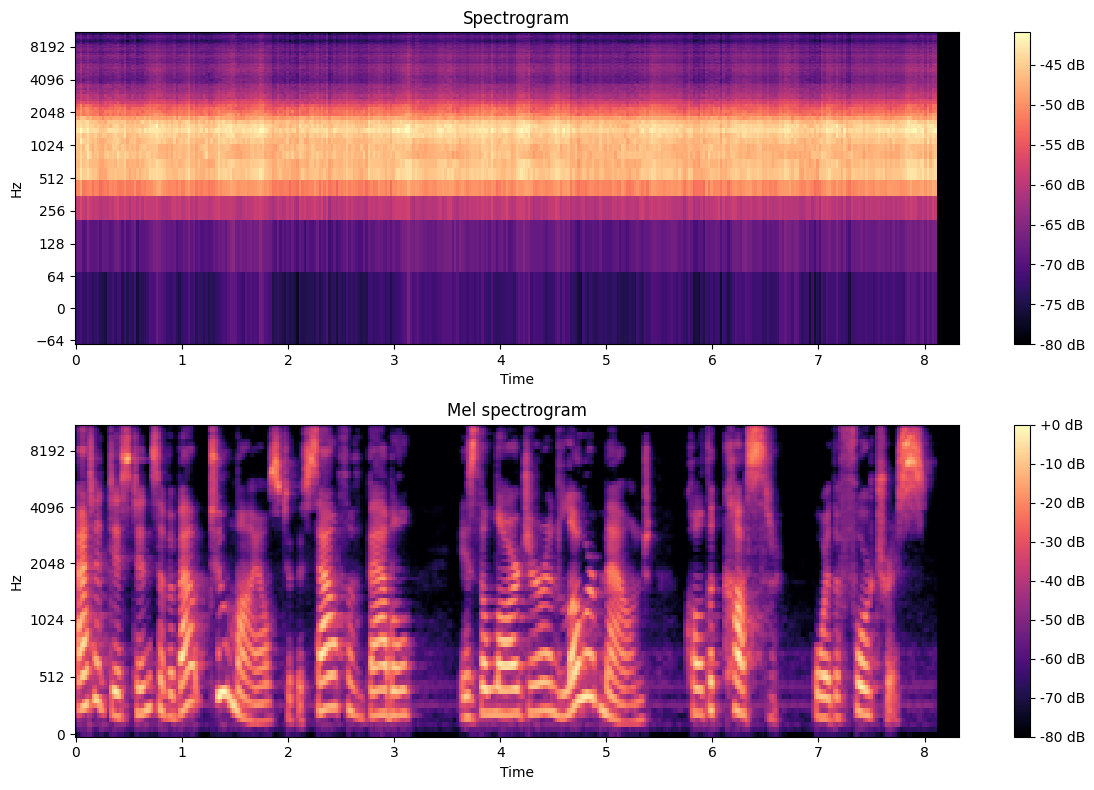

phoneme torch.Size([4, 104]), spec: torch.Size([4, 1025, 339]), mel: torch.Size([4, 80, 339]), stop: torch.Size([4, 339]), seq_len: tensor([219, 339, 197, 287])
tensor([219, 339, 197, 287])
- model information
phoneme을 512차원 embedding vector로 변환 torch.Size([4, 104, 512])
encoder_prenet_out torch.Size([4, 104, 512])
positional_encoded torch.Size([4, 104, 512])
decoder_prenet_out torch.Size([4, 339, 512])
positional_encoded torch.Size([4, 339, 512])


KeyboardInterrupt: 

In [258]:
transformer_tts_dataset = TransformerTTSDataset()
dataloader = DataLoader(transformer_tts_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

model = TransformerTTS()
criterion = TransformerTTSLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

print(len(dataloader))

# 데이터로더에서 데이터를 가져와서 확인하기
for i, data in enumerate(dataloader):
    phoneme, spec, mel, stop, seq_len = data
    print(f'phoneme {phoneme.shape}, spec: {spec.shape}, mel: {mel.shape}, stop: {stop.shape}, seq_len: {seq_len}')
    print(seq_len)

    print("- model information")
    mel_pred, stop_pred = model(phoneme, mel, seq_len)

    loss = criterion(mel_pred, mel, stop_pred, stop)
    print(f'loss: {loss.item()}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 2 == 0:
        visualize_specs(mel_pred[0].detach().numpy(), mel[0].detach().numpy(), sr=22050)